 <font color='blue'><h2>Pojet Web Scrapping : Meilleurs films en 2022</h2></font></center>









##Sommaire

- <font color='green'>Importation des librairies</font>
- <font color='blue'>Web Scrapping</font>
- <font color='red'>Feature Engineering</font>
- <font color='purple'>Analyse Statistique</font>
- <font color='orange'>Filtrage et Modèle NLP</font>


---

# Importation des librairies

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=89bfece736e17b558f05fabc252bd3f14db07c468544389e3f2ca0e4b058865f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
!pip install findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark import HiveContext ,SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import split, col
from pyspark.sql.functions import col, explode, split
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import when
from pyspark.sql.functions import col, round
import requests
from lxml import html
from bs4 import BeautifulSoup
import pandas as pd


---

# Web Scrapping

---

######<font color='orange'>Ici nous avons créé une boucle parcourt les pages (de 1 à 14) contenant les films en 2022 sur Allociné. Pour chaque page, le code extrait des informations telles que le titre, le réalisateur, les acteurs, les notes de la presse et des spectateurs, les genres, la durée, le résumé et le lien vers la bande-annonce.Ensuite les informations extraites sont stockées dans un dictionnaire pour chaque film, puis ces dictionnaires sont ajoutés à une liste films_data.Enfin, la liste de dictionnaires est convertie en un DataFrame pandas pour une analyse et une manipulation plus faciles des données.





In [ ]:
films_data = []

# Boucle à travers les pages de 1 à 14
for page_number in range(1, 15):
    url = f"https://www.allocine.fr/film/meilleurs/decennie-2020/annee-2022/?page={page_number}"
    page = requests.get(url)
    tree = html.fromstring(page.content)

    # Récupération des données spécifiques à chaque page
    films = tree.xpath('//div[@class="meta  meta-affintiy-score"]')

    i = 0

    for film in films:
        # Web scraping pour obtenir le titre, le réalisateur ,le résumé du film

        title = film.xpath('.//a[@class="meta-title-link"]/text()')[0]
        realisateur = film.xpath('.//a[@class="blue-link"]/text()')
        resume = film.xpath('//div[@class="content-txt "]/text()')[i]
        i+=1

        # Web scraping pour obtenir tous les url des bande d'annonce  des films
        trailer_url = "https://www.allocine.fr" + film.xpath('.//a[@class="meta-title-link"]/@href')[0] if film.xpath('.//a[@class="meta-title-link"]/@href') else ''
        trailer_page = requests.get(trailer_url)
        trailer_soup = BeautifulSoup(trailer_page.text, 'html.parser')
        # Web scraping pour obtenir toutes les notes

        note_spans = trailer_soup.find_all('span', class_='stareval-note')
        notes = [note_span.text.strip() for note_span in note_spans]

        # Récupération des types et des durées spécifiques à chaque film
        types = film.xpath('.//span[contains(@class, "ACrL2ZACrpbG1z")]/text()')
        durée = film.xpath('.//div[@class="meta-body-item meta-body-info"]/text()')[0]

        # Web scraping pour obtenir la liste des acteurs
        actors_span = film.xpath('.//div[@class="meta-body-item meta-body-actor"]')[0]
        actors = actors_span.xpath('.//a/text()')

        # Stockez les données dans un dictionnaire
        film_data = {
            'Titre': title,
            'Réalisateur': ', '.join(realisateur),
            'Acteurs': ', '.join(actors),
            'Note Presse': notes[0] if len(notes) > 0 else '',
            'Note Spectateurs': notes[1] if len(notes) > 1 else '',
            'Types': ', '.join(types),
            'Durée': durée,
            'Résumé': resume,
            'Lien de bande-annonce': trailer_url
        }

        films_data.append(film_data)

df = pd.DataFrame(films_data)



In [ ]:
df.to_csv('scrapping.csv', index=True)


---

# Feature Engineering

---

### <font color='blue'>Importation de la dataframe





In [ ]:

# Création de la session Spark
spark = SparkSession.builder.appName("Lecture_CSV").getOrCreate()

# Chargement du fichier CSV dans un DataFrame
df = spark.read.csv('/content/scrapping.csv', header=True, multiLine=True, escape='"', inferSchema=True)

# Ajouter un espace après le dernier caractère (|) dans la colonne "Lien de bande-annonce"
df = df.withColumn("Lien de bande-annonce", expr("coalesce(`Lien de bande-annonce`, '') || ' '"))

# Sélection des colonnes que vous souhaitez afficher
df_select = df.select("Titre", "Réalisateur", "Acteurs", "Note Presse", "Note Spectateurs", "Types", "Durée", "Résumé", "Lien de bande-annonce")

# Affichage du DataFrame sélectionné
df_select.show(truncate=False)


+-----------------------------------+---------------------------------+-------------------------------------------------+-----------+----------------+--------------------------------------+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------+
|Titre                              |Réalisateur                      |Acteurs                                          |Note Presse|Note Spectateurs|Types                                 |Durée       |Résumé                                                                                                                         

### <font color='blue'> Traitement de la Dataframe

In [ ]:

#Traitement des colonnes Durée et Résumé
df_select = df_select.withColumn('Durée', regexp_replace('Durée', '\\n', ''))
df_select = df_select.withColumn('Résumé', regexp_replace('Résumé', '\\n', ''))


In [ ]:

# Séparation de la colonne Durée en Heures et Minutes
df_select = df_select.withColumn('Heures', split(col('Durée'), 'h').getItem(0).cast('int'))
df_select = df_select.withColumn('Minutes', split(split(col('Durée'), 'h').getItem(1), 'min').getItem(0).cast('int'))


In [ ]:

# Convertir la colonne Types de chaînes en une seule chaîne
df_select = df_select.withColumn("TypesAsString", concat_ws(", ", df_select["Types"]))

# Diviser la colonne "TypesAsString" en une liste d'éléments distincts
df_split = df_select.withColumn("TypeList", split(df_select["TypesAsString"], ", "))

# Créer de nouvelles colonnes pour chaque type distinct
max_types = df_split.selectExpr("max(size(TypeList))").collect()[0][0]

for i in range(max_types):
    col_name = f"Type_{i+1}"
    df_split = df_split.withColumn(col_name, df_split["TypeList"][i])

df_split.show(truncate=False)


# Supprimer les colonnes "TypesAsString" et "TypeList"
df_final = df_split.drop("TypesAsString", "TypeList")

+-----------------------------------+---------------------------------+-------------------------------------------------+-----------+----------------+--------------------------------------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------+------+-------+--------------------------------------+----------------------------------------+------------------+--------+-----------+
|Titre                              |Réalisateur                      |Acteurs                                          |Note Presse|Note Spectateurs|Types                                 |Durée   |Résu

In [ ]:
# Convertir les colonnes en format numérique en remplaçant les virgules par des points

def convert_columns_to_floats(dataframe, columns_list):
    for column_name in columns_list:
        dataframe = dataframe.withColumn(column_name, regexp_replace(col(column_name), ",", ".").cast("float"))
    return dataframe

# Liste des colonnes à convertir
columns_to_convert = ["Note Presse", "Note Spectateurs"]

# Appel de la fonction pour convertir les colonnes spécifiées
df_final = convert_columns_to_floats(df_final, columns_to_convert)

In [ ]:
# Pour connaître le nombre de lignes dans un DataFrame
nb_lignes = df_split.count()
print("Nombre de lignes dans le DataFrame : ", nb_lignes)

Nombre de lignes dans le DataFrame :  139


In [ ]:
df_final.select("Note Presse").summary().show()

+-------+-------------------+
|summary|        Note Presse|
+-------+-------------------+
|  count|                139|
|   mean| 3.5690647372238926|
| stddev|0.47774363518084634|
|    min|                1.3|
|    25%|                3.3|
|    50%|                3.7|
|    75%|                3.9|
|    max|                4.9|
+-------+-------------------+



In [ ]:
df_final.select("Note Spectateurs").summary().show()

+-------+------------------+
|summary|  Note Spectateurs|
+-------+------------------+
|  count|               122|
|   mean|3.8368852216689313|
| stddev|0.2073846578460868|
|    min|               3.5|
|    25%|               3.7|
|    50%|               3.8|
|    75%|               4.0|
|    max|               4.3|
+-------+------------------+



#####<font color='orange'>  Remarque :Il y'a 139 lignes dans notres data , et 139 valeurs pour la note presse mais 122 pour la variable note spéctateurs donc on ades valeurs manquantes dans cette colonne

In [ ]:
# Remplacer les "--" par None dans la colonne "Note Spectateurs"
df_final = df_final.withColumn("Note Spectateurs",
    when(col("Note Spectateurs") == "--", None)
    .otherwise(col("Note Spectateurs")))

In [ ]:

# nombre de lignes avec des valeurs manquantes ou None dans la colonne "Note Spectateurs"
df_final.filter(col("Note Spectateurs").isNull()).count()


17

In [ ]:
#voir les lignes avec des nan dans la colonne note spectateurs
column_name = "Note Spectateurs"
null_values = df_final.filter(col(column_name).isNull())
null_values.show()

+--------------------+--------------------+--------------------+-----------+----------------+--------------------+--------+--------------------+---------------------+------+-------+---------+-----------------+----------+
|               Titre|         Réalisateur|             Acteurs|Note Presse|Note Spectateurs|               Types|   Durée|              Résumé|Lien de bande-annonce|Heures|Minutes|   Type_1|           Type_2|    Type_3|
+--------------------+--------------------+--------------------+-----------+----------------+--------------------+--------+--------------------+---------------------+------+-------+---------+-----------------+----------+
|A l'Ouest, rien d...|       Edward Berger|Felix Kammerer, A...|        4.1|            NULL|Drame, Guerre, Hi...|2h 28min|L'histoire poigna...| https://www.alloc...|     2|     28|    Drame|           Guerre|Historique|
|                 RRR|      S.S. Rajamouli|N. T. Rama Rao Jr...|        4.1|            NULL|Action, Drame, Hi...|3h

######<font color='red'>Ici nous avons décidé d'imputer les valeurs manquantes de la colonne Note Spectateurs par la moyenne (3.8) de cette colonne car nous avons vu que en général ce sont  des films qui ont une note de presse assez proche , ce qui nous semblait logique

In [ ]:
# Remplacer les valeurs None par 0 dans la colonne "Note Spectateurs"
df_final = df_final.withColumn("Note Spectateurs", when(col("Note Spectateurs").isNull(), 3.8).otherwise(col("Note Spectateurs")))

In [ ]:
df_final.select("Note Presse").summary().show()

+-------+-------------------+
|summary|        Note Presse|
+-------+-------------------+
|  count|                139|
|   mean| 3.5690647372238926|
| stddev|0.47774363518084634|
|    min|                1.3|
|    25%|                3.3|
|    50%|                3.7|
|    75%|                3.9|
|    max|                4.9|
+-------+-------------------+



In [ ]:
df_final.select("Note Spectateurs").summary().show()

+-------+------------------+
|summary|  Note Spectateurs|
+-------+------------------+
|  count|               139|
|   mean|  3.83237407945043|
| stddev|0.1945696864869538|
|    min|               3.5|
|    25%| 3.700000047683716|
|    50%|               3.8|
|    75%|               4.0|
|    max| 4.300000190734863|
+-------+------------------+



In [ ]:

# vérifier si ils restent des Nan
df_final.filter(col("Note Spectateurs").isNull()).count()

0

In [ ]:
# Arrondir une colonne à un chiffre après la virgule
df_final = df_final.withColumn("Note Spectateurs", round(df_final["Note Spectateurs"], 1))

In [ ]:
# Créer une nouvelle colonne contenant la moyenne des notes
df_final = df_final.withColumn("Note Moyenne", (col("Note Presse") + col("Note Spectateurs")) / 2)

In [ ]:

# Arrondir une colonne à un chiffre après la virgule
df_final = df_final.withColumn("Note Moyenne", round(df_final["Note Moyenne"], 1))

######<font color='red'>Ici nous avons décidé de définir les seuils pour les catégories en prenant le moyenne des premiers quartils et des troisièmes quartils des deux notes presse et spéctateurs


In [ ]:

# Définir les seuils pour les catégories
seuil_faible = 3.4
seuil_bien = 3.95

# Ajouter une colonne avec les catégories de notes
df_final = df_final.withColumn("Catégorie_Générale",
    when(col("Note Moyenne") < seuil_faible, "faibe")
    .when((col("Note Moyenne") >= seuil_faible) & (col("Note Moyenne") < seuil_bien), "Moyen")
    .otherwise("Bien")
)


In [ ]:
df_final.show()

+--------------------+--------------------+--------------------+-----------+----------------+--------------------+--------+--------------------+---------------------+------+-------+------------------+--------+-----------+------------+------------------+
|               Titre|         Réalisateur|             Acteurs|Note Presse|Note Spectateurs|               Types|   Durée|              Résumé|Lien de bande-annonce|Heures|Minutes|            Type_1|  Type_2|     Type_3|Note Moyenne|Catégorie_Générale|
+--------------------+--------------------+--------------------+-----------+----------------+--------------------+--------+--------------------+---------------------+------+-------+------------------+--------+-----------+------------+------------------+
|   Top Gun: Maverick|     Joseph Kosinski|Tom Cruise, Miles...|        3.7|             4.3|              Action|2h 11min|Après avoir été l...| https://www.alloc...|     2|     11|            Action|    NULL|       NULL|         4.0|    

In [ ]:
# Créer une nouvelle colonne contenant la la durée totale en min
df_final = df_final.withColumn("Durée Totale(min)", ((col("Heures")*60)+ col("Minutes")) )

---

# Analyse Statistique

---

In [ ]:
# Pour connaître le nombre de lignes dans un DataFrame
nb_lignes = df_split.count()
print("Nombre de lignes dans le DataFrame : ", nb_lignes)

Nombre de lignes dans le DataFrame :  139


In [ ]:
#Stat descriptives
df_final.describe(["Note Presse", "Note Spectateurs","Note Moyenne" ,"Durée Totale(min)"]).show()

+-------+-------------------+------------------+-------------------+------------------+
|summary|        Note Presse|  Note Spectateurs|       Note Moyenne| Durée Totale(min)|
+-------+-------------------+------------------+-------------------+------------------+
|  count|                139|               139|                139|               139|
|   mean| 3.5690647372238926|  3.83237410071943| 3.7057553956834526|             117.0|
| stddev|0.47774363518084634|0.1945696951760169|0.27577815705577846|22.313640463282493|
|    min|                1.3|               3.5|                2.5|                61|
|    max|                4.9|               4.3|                4.6|               192|
+-------+-------------------+------------------+-------------------+------------------+



In [ ]:

# Grouper les films par type et compter le nombre de films pour chaque type
films_par_type = df.groupBy("Types").count().orderBy(col("count").desc())

# Afficher les films par type
films_par_type.show()


+--------------------+-----+
|               Types|count|
+--------------------+-----+
|               Drame|   41|
|             Comédie|    6|
|      Drame, Romance|    6|
|Comédie dramatiqu...|    4|
|     Drame, Thriller|    4|
|       Biopic, Drame|    4|
|     Thriller, Drame|    4|
|      Drame, Comédie|    3|
|  Comédie dramatique|    3|
|   Historique, Drame|    3|
|            Thriller|    2|
|    Comédie, Romance|    2|
|Thriller, Policie...|    2|
|       Drame, Biopic|    2|
|  Animation, Famille|    2|
|   Drame, Historique|    2|
|  Thriller, Policier|    2|
|Comédie dramatiqu...|    2|
|Animation, Comédi...|    2|
|      Romance, Drame|    2|
+--------------------+-----+
only showing top 20 rows



In [ ]:
import plotly.express as px

data = df_final.select("Note Presse", "Note Spectateurs").toPandas()

fig = px.histogram(data, x=["Note Presse", "Note Spectateurs"], marginal="rug", title="Distribution des notes")
fig.update_layout(bargap=0.1)
fig.show()


In [ ]:
import plotly.express as px

data = df_final.groupBy("Catégorie_Générale").count().toPandas()

fig = px.bar(data, x="Catégorie_Générale", y="count", title="Décompte des catégories")
fig.show()


######<font color='Orange'> Fréquence de chaque type dans notre base

In [ ]:
from pyspark.sql.functions import split, explode, col, count

# Diviser la colonne "Types" en mots et utiliser explode pour obtenir un mot par ligne
unique_words = df_final.select(explode(split(col("Types"), ", ")).alias("Unique_Word"))

# Grouper par le mot unique et compter la fréquence
word_frequencies = unique_words.groupBy("Unique_Word").agg(count("*").alias("Frequency"))

# Afficher les mots uniques avec leur fréquence
word_frequencies.show(truncate=False)

+------------------+---------+
|Unique_Word       |Frequency|
+------------------+---------+
|Judiciaire        |1        |
|Romance           |14       |
|Thriller          |18       |
|Famille           |7        |
|Historique        |10       |
|Comédie           |23       |
|Epouvante-horreur |1        |
|Aventure          |11       |
|Fantastique       |7        |
|Comédie dramatique|10       |
|Policier          |11       |
|Musical           |2        |
|Animation         |15       |
|Biopic            |12       |
|Science Fiction   |2        |
|Guerre            |4        |
|Drame             |98       |
|Évènement Sportif |1        |
|Action            |13       |
+------------------+---------+



######<font color='orange'>Occurrences des catégories générales par Type 1

In [ ]:
from pyspark.sql.functions import col

# Regrouper par Type_1 et Catégorie_Générale et compter le nombre d'occurrences
occurrences = df_final.groupBy("Type_1", "Catégorie_Générale").count().orderBy("Type_1")

# Afficher le résultat
occurrences.show()


+------------------+------------------+-----+
|            Type_1|Catégorie_Générale|count|
+------------------+------------------+-----+
|            Action|              Bien|    2|
|            Action|             Moyen|    3|
|         Animation|              Bien|    6|
|         Animation|             Moyen|    9|
|          Aventure|             Moyen|    1|
|          Aventure|             faibe|    1|
|            Biopic|             Moyen|    6|
|            Biopic|              Bien|    2|
|           Comédie|             Moyen|    7|
|           Comédie|              Bien|    1|
|           Comédie|             faibe|    1|
|Comédie dramatique|             faibe|    1|
|Comédie dramatique|             Moyen|    9|
|             Drame|             Moyen|   55|
|             Drame|             faibe|    5|
|             Drame|              Bien|    6|
|       Fantastique|             Moyen|    1|
|            Guerre|             Moyen|    1|
|        Historique|             f

In [ ]:
import plotly.express as px
import pandas as pd

# Convertir les données PySpark en DataFrame pandas
occurrences_pandas = occurrences.toPandas()

# Créer un graphique à barres empilées avec Plotly
fig = px.bar(occurrences_pandas, x='Catégorie_Générale', y='count', color='Type_1',
             title='Occurrences des catégories générales par Type 1',
             labels={'count': 'Nombre d\'occurrences', 'Catégorie_Générale': 'Catégorie Générale'},
             barmode='group')

# Afficher le graphique
fig.show()


######<font color='orange'>Note Moyenne Par Type1

In [ ]:
from pyspark.sql import functions as F

# Supposons que votre DataFrame s'appelle df
grouped_df = df_final.groupBy("Type_1").agg(F.avg("Note Moyenne").alias("Note_Moyenne_Par_Type1"))

# Afficher le résultat
grouped_df.show(truncate=False)

+------------------+----------------------+
|Type_1            |Note_Moyenne_Par_Type1|
+------------------+----------------------+
|Romance           |3.8                   |
|Thriller          |3.7600000000000002    |
|Historique        |3.46                  |
|Comédie           |3.466666666666667     |
|Aventure          |3.3                   |
|Fantastique       |3.4                   |
|Comédie dramatique|3.6799999999999997    |
|Policier          |3.7                   |
|Animation         |3.8266666666666667    |
|Biopic            |3.8125                |
|Science Fiction   |3.8                   |
|Guerre            |3.7                   |
|Drame             |3.7106060606060596    |
|Action            |3.84                  |
+------------------+----------------------+



In [ ]:
import plotly.express as px
import pandas as pd

# Convertir le DataFrame Spark en Pandas
grouped_pandas = grouped_df.toPandas()

# Créer un graphique à barres avec Plotly
fig = px.bar(grouped_pandas, x='Type_1', y='Note_Moyenne_Par_Type1',
             title='Note moyenne par Type 1',
             labels={'Note_Moyenne_Par_Type1': 'Note Moyenne', 'Type_1': 'Type 1'})

# Afficher le graphique
fig.show()


######<font color='orange'>Moyen des notes presse et spéctateurs  par Type1




In [ ]:

grouped_df = df_final.groupBy("Type_1").agg(
    F.avg("Note Spectateurs").alias("Moyenne_Note_Spectateurs"),
    F.avg("Note Presse").alias("Moyenne_Note_Presse")
)

grouped_df.show(truncate=False)

+------------------+------------------------+-------------------+
|Type_1            |Moyenne_Note_Spectateurs|Moyenne_Note_Presse|
+------------------+------------------------+-------------------+
|Romance           |3.775                   |3.800000011920929  |
|Thriller          |3.9                     |3.609999966621399  |
|Historique        |3.9200000000000004      |3.0199999809265137 |
|Comédie           |3.688888888888889       |3.244444396760729  |
|Aventure          |3.6                     |3.049999952316284  |
|Fantastique       |3.6                     |3.200000047683716  |
|Comédie dramatique|3.8300000000000005      |3.509999990463257  |
|Policier          |3.6                     |3.799999952316284  |
|Animation         |3.9599999999999995      |3.680000003178914  |
|Biopic            |3.95                    |3.6749999821186066 |
|Science Fiction   |3.85                    |3.8499999046325684 |
|Guerre            |3.8                     |3.5999999046325684 |
|Drame    

In [ ]:
import plotly.express as px
import pandas as pd

grouped_pandas = grouped_df.toPandas()

fig = px.bar(grouped_pandas, x='Type_1', y=['Moyenne_Note_Spectateurs', 'Moyenne_Note_Presse'],
             title='Moyennes des Notes par Type 1',
             labels={'value': 'Note Moyenne', 'Type_1': 'Type 1'},
             barmode='group')

fig.show()


######<font color='orange'>Distribustion des durées de films et Durée moyenne par catégorie générale et par type


In [ ]:
import plotly.express as px

# Collecter les données
data_duree = df_final.select("Durée Totale(min)").toPandas()

# Créer un histogramme avec Plotly
fig = px.histogram(data_duree, x="Durée Totale(min)", title="Distribution de la durée en minutes")
fig.update_layout(bargap=0.1)
fig.show()


In [ ]:
import plotly.express as px

data_duree_categorie = df_final.groupBy("Catégorie_Générale").avg("Durée Totale(min)").toPandas()
fig = px.bar(data_duree_categorie, x="Catégorie_Générale", y="avg(Durée Totale(min))",
             title="Durée moyenne par catégorie générale")
fig.update_xaxes(title="Catégorie")
fig.update_yaxes(title="Durée moyenne (minutes)")
fig.show()



In [ ]:
import plotly.express as px

data_duree_type1 = df_final.groupBy("Type_1").avg("Durée Totale(min)").toPandas()
fig = px.bar(data_duree_type1, x="Type_1", y="avg(Durée Totale(min))",
             title="Durée moyenne par Type 1")
fig.update_xaxes(title="Type 1")
fig.update_yaxes(title="Durée moyenne (minutes)")
fig.show()


---

# Filtrage et Modèle NLP

---

######<font color='red'>Ici nous avons implémenté une fonction qui permet de filtrer la data en choisissant la colonne sur la quelle on veut filtrer et le choix désiré

In [ ]:
def filter_and_display(colonne, filtrer, df_select):
    # Filtrer le DataFrame en fonction du réalisateur
    filtered_df = df_select.filter(col(colonne) == filtrer)

    if filtered_df.count() == 0:
        print(f"Aucun film trouvé pour le {colonne} {filtrer}.")
    else:
        print(f"Films du {colonne} {filtrer}:")
        filtered_df.show(truncate=False)

In [ ]:
# Exemple d'utilisation
colonne = "Types"
filtrer = "Drame"
filter_and_display(colonne, filtrer, df_final.select("Titre", "Réalisateur", "Acteurs", "Durée", "Lien de bande-annonce"))

Films du Types Drame:
+-------------------------+---------------------------------------------+-----------------------------------------------------------------+--------+-------------------------------------------------------------+
|Titre                    |Réalisateur                                  |Acteurs                                                          |Durée   |Lien de bande-annonce                                        |
+-------------------------+---------------------------------------------+-----------------------------------------------------------------+--------+-------------------------------------------------------------+
|Le Retour des hirondelles|Li Ruijun                                    |Wu Renlin,  Hai-Qing                                             |2h 13min|https://www.allocine.fr/film/fichefilm_gen_cfilm=300250.html |
|Treize vies              |Ron Howard                                   |Colin Farrell, Viggo Mortensen, Joel Edgerton                

# 1 Importation dataframe

In [ ]:
df_final.printSchema()


root
 |-- Titre: string (nullable = true)
 |-- Réalisateur: string (nullable = true)
 |-- Acteurs: string (nullable = true)
 |-- Note Presse: float (nullable = true)
 |-- Note Spectateurs: double (nullable = true)
 |-- Types: string (nullable = true)
 |-- Durée: string (nullable = true)
 |-- Résumé: string (nullable = true)
 |-- Lien de bande-annonce: string (nullable = false)
 |-- Heures: integer (nullable = true)
 |-- Minutes: integer (nullable = true)
 |-- Type_1: string (nullable = true)
 |-- Type_2: string (nullable = true)
 |-- Type_3: string (nullable = true)
 |-- Note Moyenne: double (nullable = true)
 |-- Catégorie_Générale: string (nullable = false)
 |-- Durée Totale(min): integer (nullable = true)



In [ ]:
df_final

DataFrame[Titre: string, Réalisateur: string, Acteurs: string, Note Presse: float, Note Spectateurs: double, Types: string, Durée: string, Résumé: string, Lien de bande-annonce: string, Heures: int, Minutes: int, Type_1: string, Type_2: string, Type_3: string, Note Moyenne: double, Catégorie_Générale: string, Durée Totale(min): int]

In [ ]:
from pyspark.sql import SparkSession, functions as F

# Créer une session Spark
# spark = SparkSession.builder.appName("example").getOrCreate()

# Convertir la colonne 'TypesList' en une chaîne de caractères
#df_final_csv = df_final.withColumn("TypesListAsString", F.concat_ws(',', df_final["TypesList"]))

# Sélectionner toutes les colonnes nécessaires
selected_columns = ["Titre", "Réalisateur", "Acteurs", "Note Presse", "Note Spectateurs", "Types", "Durée", "Résumé",
                    "Lien de bande-annonce", "Heures", "Minutes", "Type_1", "Type_2", "Type_3",
                    "Note Moyenne", "Catégorie_Générale", "Durée Totale(min)"]

# Réduire le nombre de partitions à 1
df_final_csv = df_final.coalesce(1)

# Convertir le DataFrame Spark en DataFrame pandas
df = df_final_csv.toPandas()

# Enregistrer le DataFrame pandas en tant que fichier CSV
# df_final_pandas[selected_columns].to_csv("/content/df_final_export.csv", index=False)


# df_final_pandas[selected_columns].to_csv("/content/drive/MyDrive/Mosef/Python_avance_Mosef/df_final1.csv", index=False)


In [ ]:
import pandas as pd

print(df.head())

                       Titre       Réalisateur  \
0          Top Gun: Maverick   Joseph Kosinski   
1              The Fabelmans  Steven Spielberg   
2        The First Slam Dunk    Takehiko Inoue   
3          Le Bleu du Caftan    Maryam Touzani   
4  Avatar : la voie de l'eau     James Cameron   

                                          Acteurs  Note Presse  \
0     Tom Cruise, Miles Teller, Jennifer Connelly          3.7   
1   Gabriel LaBelle, Michelle Williams, Paul Dano          4.9   
2     Shugo Nakamura, Subaru Kimura, Kenta Miyake          3.9   
3       Lubna Azabal, Saleh Bakri, Ayoub Missioui          3.8   
4  Sam Worthington, Zoe Saldana, Sigourney Weaver          4.1   

   Note Spectateurs                                   Types     Durée  \
0               4.3                                  Action  2h 11min   
1               4.3                           Biopic, Drame  2h 31min   
2               4.2               Animation, Comédie, Drame  2h 04min   
3         

# 3) Nettoyage

In [ ]:
!pip install stop-words


  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=72e362d53d1483349b8bbab8ed79a9b591a0c304303a9a01731eb0f6befff37d
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [ ]:
!pip install transformers


In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow


In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from stop_words import get_stop_words
from unidecode import unidecode

# nltk.download('stopwords')
nltk.download('punkt')

def clean_text_french(text):
    # Convertir le texte en minuscules
    text = text.lower()

    # Supprimer les accents, les apostrophes, et les guillemets
    text = unidecode(text).replace("'", "").replace('"', '')

    # Supprimer la ponctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Supprimer les chiffres sauf ceux suivis de quatre chiffres (pour les années) car utile pour le theme historique
    # Apres reflexions nous avons pas supprimer les chiffres car indiquer l'age dans un resumer impacte le theme
    #text = re.sub(r'\b\d{1,3}\b|(?<!\d)\d{5,}(?!\d)', '', text)

    # Tokenization (division en mots)
    words = word_tokenize(text, language='french')

    # Supprimer les stopwords en français
    stop_words = set(get_stop_words('fr'))
    #words = [word for word in words if word not in stop_words]

    # Stemming (racinisation) en français
    stemmer = SnowballStemmer('french')
    words = [stemmer.stem(word) for word in words]

    # Rejoindre les mots pour reformer le texte
    cleaned_text = ' '.join(words)

    return cleaned_text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


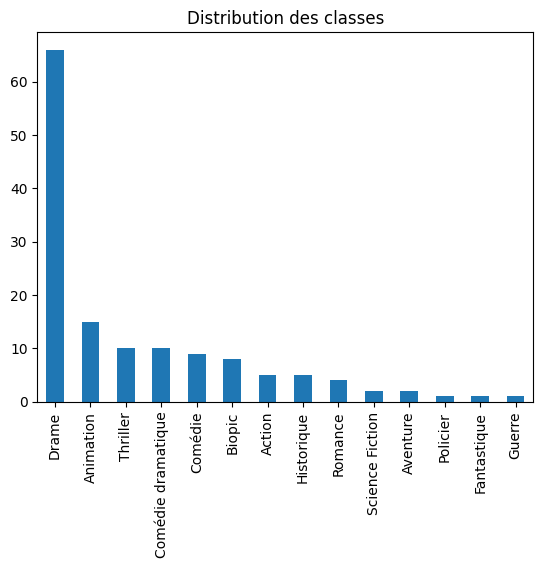

In [ ]:
# Visualiser la distribution des classes
import matplotlib.pyplot as plt

df['Type_1'].value_counts().plot(kind='bar')
plt.title('Distribution des classes')
plt.show()


In [ ]:

# Appliquer la fonction de nettoyage textuelle à la colonne "Résumé"
df["Résumé_propre"] = df["Résumé"].apply(clean_text_french)

# Créer un nouveau DataFrame avec la colonne "Résumé_propre" et rajout de 'Type_1'
df_nouveau_resume_nlp= df[["Résumé_propre"]]
df_nouveau_resume_nlp["Type_1"] = df["Type_1"]


<ipython-input-84-d0b1402f1943>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Pour le desequilibre
df_nouveau_resume_nlp_copy = df_nouveau_resume_nlp.copy()
# Fixez une valeur pour le random_state (par exemple, 42)
random_state_value = 42
# Sélection aléatoire de 40 indices de lignes où Type_1 est égal à "Drame"
indices_a_supprimer = df_nouveau_resume_nlp_copy[df_nouveau_resume_nlp_copy['Type_1'] == 'Drame'].sample(40, random_state=random_state_value).index
# Suppression des lignes correspondantes de la DataFrame
df_nouveau_resume_nlp_copy = df_nouveau_resume_nlp_copy.drop(indices_a_supprimer)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# encodage sur colonne cible
df_nouveau_resume_nlp_copy ["Type_1_encoded"] = label_encoder.fit_transform(df_nouveau_resume_nlp_copy ["Type_1"])
# Affichez le mapping entre les classes originales et les valeurs encodées
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping des classes :", class_mapping)


Mapping des classes : {'Action': 0, 'Animation': 1, 'Aventure': 2, 'Biopic': 3, 'Comédie': 4, 'Comédie dramatique': 5, 'Drame': 6, 'Fantastique': 7, 'Guerre': 8, 'Historique': 9, 'Policier': 10, 'Romance': 11, 'Science Fiction': 12, 'Thriller': 13}


# 1. Modele 1 avec TF IDF

# Optimisation des parametres du TF IDF

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

# Optimisation des parametres du TF IDF a l'aide d'un grid search

labels=df_nouveau_resume_nlp["Type_1"]
# Division des données en train et test
X_train, X_test, y_train, y_test = train_test_split(df_nouveau_resume_nlp["Résumé_propre"],df_nouveau_resume_nlp["Type_1"], test_size=0.2, random_state=42)

# Utilisation MultiLabelBinarizer pour convertir les listes de classes en représentation binaire
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

# Définission des paramètres à optimiser
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__min_df': [1,5],
    'tfidf__max_df': [0.9, 0.95,0.99],
    # Ajoutez d'autres paramètres ici
}

# Créeation pipeline avec le modèle et le vecteur TF-IDF
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=500, random_state=42))
])

# Utilisation GridSearchCV pour la recherche des paramètres
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning:

unknown class(es) ['G'] will be ignored



Meilleurs paramètres trouvés :
{'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}


# TF IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(norm='l2', ngram_range=(1, 3),max_df=0.9, min_df=1)

# Fit and transform sur les rasume
tfidf_matrix = tfidf_vectorizer.fit_transform(df_nouveau_resume_nlp_copy['Résumé_propre'])

# feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Conversion matrice TF-IDF en DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df.head()


,12,13,13 novembr,14,14 an,14 an emmet,15,15 avril,15 avril 2019,1516,...,yut qui mem,zaph,zo,zo et,zo et vient,zo grand,zo grand au,zomb,zomb entre,zomb entre technicien
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import LabelEncoder

#  LabelEncoder pour encoder variable cycle Type_1
label_encoder = LabelEncoder()
df_nouveau_resume_nlp_copy["Type_1_encoded"] = label_encoder.fit_transform(df_nouveau_resume_nlp_copy["Type_1"])
# mapping entre les classes originales et les valeurs encodées
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping des classes :", class_mapping)


Mapping des classes : {'Action': 0, 'Animation': 1, 'Aventure': 2, 'Biopic': 3, 'Comédie': 4, 'Comédie dramatique': 5, 'Drame': 6, 'Fantastique': 7, 'Guerre': 8, 'Historique': 9, 'Policier': 10, 'Romance': 11, 'Science Fiction': 12, 'Thriller': 13}


# Ransdom Forest

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Division Ensemble de données en train et test
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, df_nouveau_resume_nlp_copy["Type_1"], test_size=0.2, random_state=42)

# Comptez le nombre d'échantillons pour chaque classe dans l'ensemble d'entraînement pour limité le desequilibre
class_counts = y_train.value_counts()

# dictionnaire de poids de classe inversément proportionnels au nombre d'échantillons
class_weights = {label: 1 / count for label, count in class_counts.items()}

# modèle Random Forest avec les poids de classe et 500 arbres
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42, class_weight=class_weights)

# Entraînement du modèle sur l'ensemble d'entraînement
rf_classifier.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = rf_classifier.predict(X_test)

# Évaluation des performances du modèle
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


Rapport de classification :
                    precision    recall  f1-score   support

            Action       0.00      0.00      0.00         3
         Animation       0.00      0.00      0.00         5
           Comédie       0.00      0.00      0.00         1
Comédie dramatique       0.00      0.00      0.00         2
             Drame       0.25      1.00      0.40         5
        Historique       0.00      0.00      0.00         2
   Science Fiction       0.00      0.00      0.00         1
          Thriller       0.00      0.00      0.00         1

          accuracy                           0.25        20
         macro avg       0.03      0.12      0.05        20
      weighted avg       0.06      0.25      0.10        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



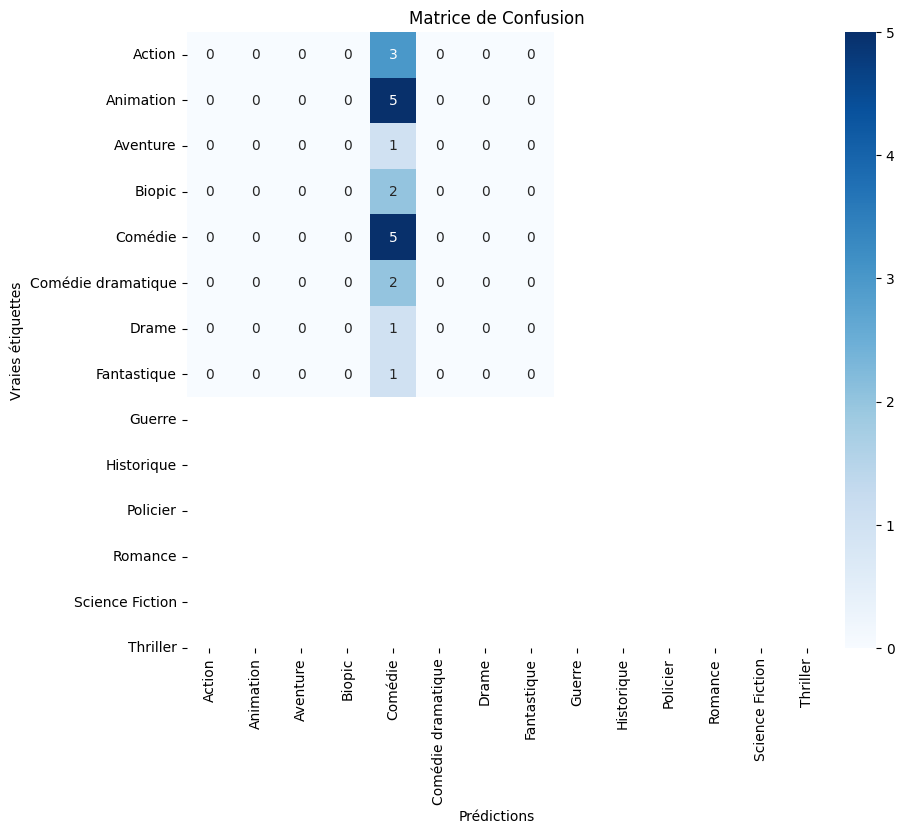

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage matrice de confusion avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.25


In [ ]:
# Accuracy ensemble train
from sklearn.metrics import accuracy_score

# Prédisez sur l'ensemble d'entraînement
y_train_pred = rf_classifier.predict(X_train)

# Calculez l'accuracy sur l'ensemble d'entraînement
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Accuracy on Training Set:", accuracy_train)
#Accuracy on Training Set: 1.0

Accuracy on Training Set: 1.0


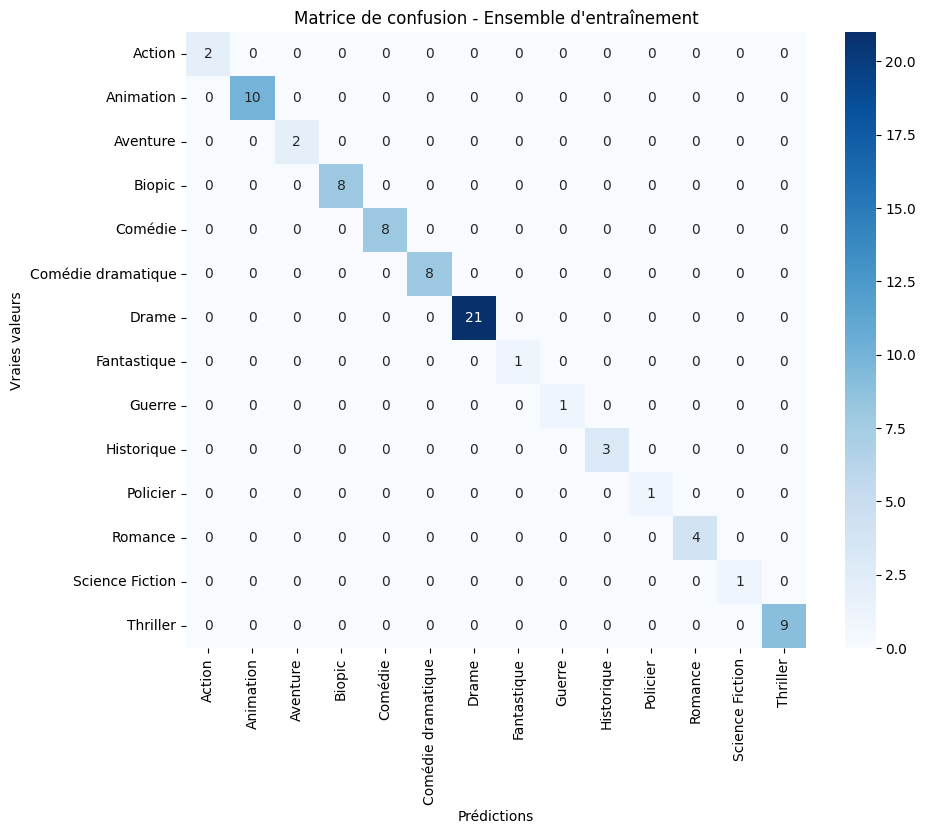

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédisez sur l'ensemble d'entraînement
y_train_pred = rf_classifier.predict(X_train)

# Calculez la matrice de confusion
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# Affichez la matrice de confusion avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion - Ensemble d\'entraînement')
plt.show()


# Modele 2 : Vectorisation avec FastText

In [ ]:
!pip install gensim

# FastText

Pendant l'entraînement du modèle Word2Vec ou FastText, les vecteurs sont ajustés de manière à ce que les mots ayant des contextes similaires aient des représentations vectorielles similaires. Ainsi, si deux mots ont des vecteurs similaires, cela suggère qu'ils sont utilisés dans des contextes similaires et partagent des propriétés sémantiques.


In [ ]:
# Création d'un modèle FastText sur le corpus
from gensim.models import FastText
from gensim.utils import simple_preprocess

# Tokenisation du corpus
tokenized_corpus = [simple_preprocess(text) for text in df_nouveau_resume_nlp_copy['Résumé_propre']]

# Création du modèle FastText
new_fasttext_model = FastText(
    sentences=tokenized_corpus,
    vector_size=300,  # La dimension des vecteurs de mots
    window=5,         # La taille de la fenêtre contextuelle
    min_count=1,      # Le nombre minimum d'occurrences d'un mot pour être inclus
    workers=4,        # Le nombre de threads utilisés pendant l'entraînement
    sg=1              # L'utilisation de Skip-gram (sg=1) ou CBOW (sg=0)
)

# Enregistrement du nouveau modèle
new_fasttext_model.save('/content/fasttext.model')


In [ ]:
# Importation des bibliothèques nécessaires
from gensim.models import FastText
from gensim.utils import simple_preprocess
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Tokenisation du corpus
tokenized_corpus = [simple_preprocess(text) for text in df_nouveau_resume_nlp_copy['Résumé_propre']]

# Chargement du nouveau modèle FastText
new_fasttext_model = FastText.load('/content/fasttext.model')

# Prétraitement du texte avec le nouveau modèle
df_nouveau_resume_nlp_copy['Cleaned_Text'] = df_nouveau_resume_nlp_copy['Résumé_propre'].apply(clean_text_french)

# Division ensemble de données en train et test
X_train, X_test, y_train, y_test = train_test_split(
    df_nouveau_resume_nlp_copy['Cleaned_Text'],
    df_nouveau_resume_nlp_copy['Type_1_encoded'],
    test_size=0.2,
    random_state=42
)

# Tokenisation (division en mots) pour le nouveau modèle FastText
tokenized_text_train = [simple_preprocess(text) for text in X_train]
tokenized_text_test = [simple_preprocess(text) for text in X_test]

# Fonction pour créer des vecteurs de texte avec le nouveau modèle FastText
def get_average_vector(text, model, vector_size):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if not vectors:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Création des vecteurs de texte pour l'ensemble d'entraînement et de test
X_train_vectors = [get_average_vector(text, new_fasttext_model, 300) for text in tokenized_text_train]
X_test_vectors = [get_average_vector(text, new_fasttext_model, 300) for text in tokenized_text_test]

# Création du modèle Random Forest
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42)

# Entraînement du modèle sur l'ensemble d'entraînement
rf_classifier.fit(X_train_vectors, y_train)

# Prédiction sur l'ensemble de test
y_pred = rf_classifier.predict(X_test_vectors)

# Évaluation des performances du modèle
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.30      0.60      0.40         5
           9       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.15        20
   macro avg       0.03      0.06      0.04        20
weighted avg       0.07      0.15      0.10        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to cont

/Users/melanieyakoub/anaconda3/envs/Projet_CO2_Melanie/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/melanieyakoub/anaconda3/envs/Projet_CO2_Melanie/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/melanieyakoub/anaconda3/envs/Projet_CO2_Melanie/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/melanieyakoub/anaconda3/envs/Projet_CO2_Melanie/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_s

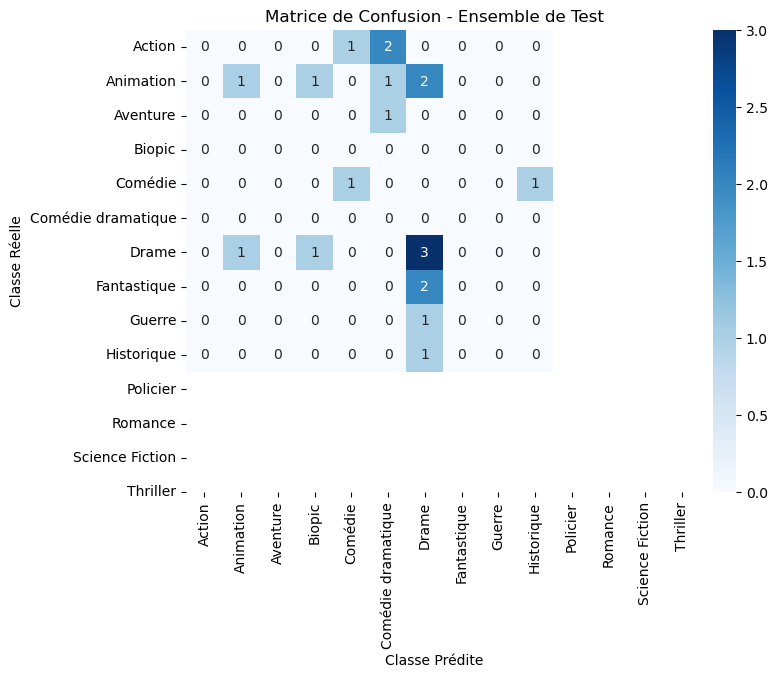

In [ ]:
# Importation des bibliothèques nécessaires
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédiction sur l'ensemble de test
y_pred = rf_classifier.predict(X_test_vectors)

# Obtention des noms de classe réels et prédits
class_names = list(class_mapping.keys())

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion - Ensemble de Test')
plt.show()


Nous observons une amélioration dans la diversité des prédictions grâce à cette technique de vectorisation, laquelle pourrait être encore plus optimisée en utilisant un modèle FastText pré-entraîné, suivi d'une étape de fine-tuning sur notre corpus spécifique.

In [ ]:
from sklearn.metrics import accuracy_score

# accuracy à partir de la matrice de confusion
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.1500


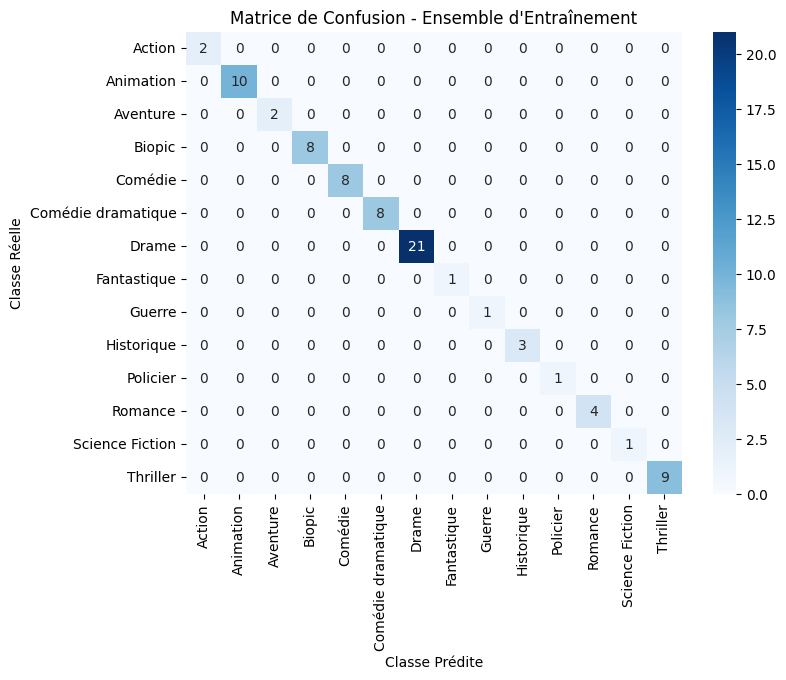

In [ ]:
# Prédiction sur l'ensemble d'entraînement
y_train_pred = rf_classifier.predict(X_train_vectors)

#  matrice de confusion pour l'ensemble d'entraînement
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion - Ensemble d\'Entraînement')
plt.show()
